# Intel Image Project

We'll work with [Intel Image Classification dataset](https://www.kaggle.com/puneet6060/intel-image-classification/version/2) from kaggle.

This is image data of natural scenes around the world. It contains around 25k images of size 150x150 distributed under 6 categories.
The Train, Test and Prediction data is separated in each zip files. There are around 14k images in Train, 3k in Test and 7k in Prediction.

In [1]:
import os
import pathlib

import numpy as np

from tqdm import tqdm
import cv2                                 
from sklearn.utils import shuffle  

import pandas as pd
import matplotlib.pyplot as plt   

import tensorflow as tf 
from keras.models import Sequential
from keras.layers import (
    Conv2D, BatchNormalization, Activation, Dropout, MaxPool2D, Flatten, Dense, 
    Resizing, Rescaling, RandomFlip, RandomRotation, RandomContrast)
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix        

import seaborn as sn; sn.set(font_scale=1.4) 


## Import the data

**Note:** If you're using Google Colab and your runtime disconnects, you may have to redownload the files. You can do this by rerunning the cells above.

In [2]:
! mkdir ~/.kaggle # create the .kaggle folder in the root directory
! echo '{"username":"panagiotis427","key":"ba4ea9629536514c923394e01146f747"}' > ~/.kaggle/kaggle.json # write kaggle API credentials to kaggle.json
! chmod 600 ~/.kaggle/kaggle.json  # set permissions
! pip install kaggle # install the kaggle library

In [3]:
! kaggle datasets download -d puneet6060/intel-image-classification/version/2 -p /content/kaggle/

 94% 327M/346M [00:02<00:00, 180MB/s]
100% 346M/346M [00:02<00:00, 166MB/s]


In [4]:
%cd kaggle
! unzip intel-image-classification

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/769

In [5]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)
train_dir = "seg_train/seg_train/"
test_dir = "seg_test/seg_test"

data_dir = pathlib.Path(train_dir) # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']


In [6]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(20,10))

    # Plot loss function
    plt.subplot(221)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(222)
    plt.plot(history.history['accuracy'],'bo--', label = "accuracy")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_accuracy")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()
    
    plt.show()

## 1. Load data & augmentation via ImageDataGenerator().flow_from_directory()

In [7]:
# Rescale the data and create augmented data generator instance
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20, # note: this is an int not a float
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(150, 150), # convert all images to be 150 x 150
                                               class_mode='categorical', # type of problem we're working on
                                               batch_size=32) # number of images to process at a time

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(150, 150),
                                             class_mode='categorical',
                                             batch_size=32)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [8]:
train_data

### Applied on a model

In [9]:
# Build the model
model_1 = Sequential([
  Conv2D(16, 3, input_shape=(150, 150, 3), padding='same'),
  BatchNormalization(),
  Activation('relu'),
  Dropout(0.1),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  BatchNormalization(),
  Activation('relu'),
  Dropout(0.1),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  BatchNormalization(),
  Activation('relu'),
  Dropout(0.1),
  MaxPool2D(),
  Conv2D(128, 3, padding='same'),
  BatchNormalization(),
  Activation('relu'),
  Dropout(0.1),
  MaxPool2D(),
  Flatten(), # flatten
  Dense(240),
  Activation('relu'),
  Dropout(0.1),
  Dense(120),
  Activation('relu'),
  Dropout(0.1),
  Dense(24),
  Activation('relu'),
  Dropout(0.1),
  Dense(6), # number of neurons same as number of classes
  Activation('softmax')
])

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [10]:
# Fit the model

checkpoint_filepath_1 = '/tmp/checkpoint1'
model_1_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_1,
    save_weights_only=True,
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True)

history_1 = model_1.fit(train_data, epochs=10, callbacks = [model_1_checkpoint_callback], steps_per_epoch=len(train_data), validation_data=test_data, validation_steps=len(test_data))

Epoch 1/10
439/439 [==============================] - ETA: 0s - loss: 1.4124 - accuracy: 0.4347
Epoch 1: val_accuracy improved from -inf to 0.50933, saving model to /tmp/checkpoint1
439/439 [==============================] - 108s 215ms/step - loss: 1.4124 - accuracy: 0.4347 - val_loss: 1.2447 - val_accuracy: 0.5093
Epoch 2/10
439/439 [==============================] - ETA: 0s - loss: 1.0830 - accuracy: 0.5671
Epoch 2: val_accuracy improved from 0.50933 to 0.68033, saving model to /tmp/checkpoint1
439/439 [==============================] - 84s 191ms/step - loss: 1.0830 - accuracy: 0.5671 - val_loss: 0.8627 - val_accuracy: 0.6803
Epoch 3/10
439/439 [==============================] - ETA: 0s - loss: 0.9545 - accuracy: 0.6345
Epoch 3: val_accuracy improved from 0.68033 to 0.69167, saving model to /tmp/checkpoint1
439/439 [==============================] - 83s 190ms/step - loss: 0.9545 - accuracy: 0.6345 - val_loss: 0.7826 - val_accuracy: 0.6917
Epoch 4/10
439/439 [=========================

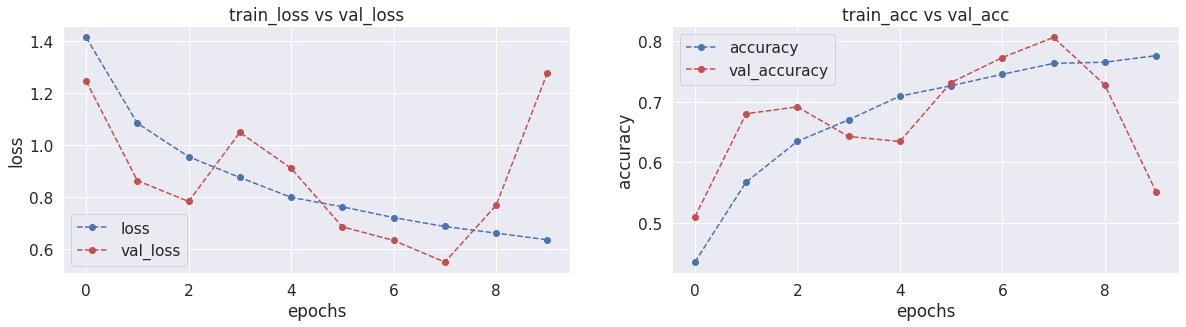

In [11]:
plot_accuracy_loss(history_1)

In [12]:
# The best model weights are loaded into the model
model_1.load_weights(checkpoint_filepath_1)

In [13]:
test_loss_1 = model_1.evaluate(test_data)

94/94 [==============================] - 4s 38ms/step - loss: 0.5500 - accuracy: 0.8067


## 2. Load data via image_dataset_from_directory & augmentation via preprocessing layers

In [14]:
batch_size = 32
img_height = 150
img_width = 150

In [15]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 14034 files belonging to 6 classes.


In [16]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3000 files belonging to 6 classes.


In [17]:
class_names = train_ds.class_names
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


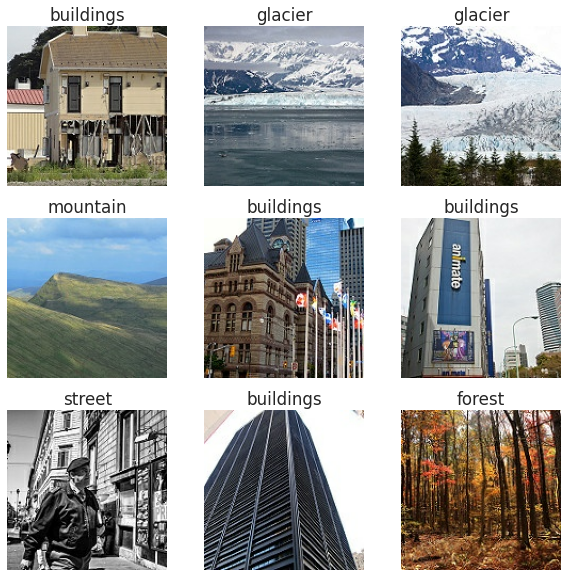

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [19]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 150, 150, 3)
(32,)


In [20]:
resize_and_rescale = Sequential([
  Resizing(img_height, img_width),
  Rescaling(1./255)
])

In [21]:
data_augmentation = Sequential([
  RandomFlip("horizontal"),
  RandomRotation(0.2),
])

In [22]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)


In [23]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)

### Applied on a model

In [24]:
# Build the model
model_2 = Sequential([
  Conv2D(16, 3, input_shape=(150, 150, 3), padding='same'),
  BatchNormalization(),
  Activation('relu'),
  Dropout(0.1),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  BatchNormalization(),
  Activation('relu'),
  Dropout(0.1),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  BatchNormalization(),
  Activation('relu'),
  Dropout(0.1),
  MaxPool2D(),
  Conv2D(128, 3, padding='same'),
  BatchNormalization(),
  Activation('relu'),
  Dropout(0.1),
  MaxPool2D(),
  Flatten(), # flatten
  Dense(240),
  Activation('relu'),
  Dropout(0.1),
  Dense(120),
  Activation('relu'),
  Dropout(0.1),
  Dense(24),
  Activation('relu'),
  Dropout(0.1),
  Dense(6), # number of neurons same as number of classes
  Activation('softmax')
])

# Compile the model
model_2.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [25]:
# Fit the model

checkpoint_filepath_2 = '/tmp/checkpoint2'
model_2_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_2,
    save_weights_only=True,
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True)

history_2 = model_2.fit(train_ds, epochs=10, callbacks = [model_2_checkpoint_callback], steps_per_epoch=len(train_ds), validation_data=val_ds, validation_steps=len(val_ds))

Epoch 1/10
438/439 [============================>.] - ETA: 0s - loss: 1.4363 - accuracy: 0.4661
Epoch 1: val_accuracy improved from -inf to 0.49033, saving model to /tmp/checkpoint2
439/439 [==============================] - 39s 69ms/step - loss: 1.4353 - accuracy: 0.4667 - val_loss: 1.3112 - val_accuracy: 0.4903
Epoch 2/10
438/439 [============================>.] - ETA: 0s - loss: 1.0912 - accuracy: 0.5871
Epoch 2: val_accuracy improved from 0.49033 to 0.56867, saving model to /tmp/checkpoint2
439/439 [==============================] - 37s 68ms/step - loss: 1.0916 - accuracy: 0.5869 - val_loss: 1.1027 - val_accuracy: 0.5687
Epoch 3/10
439/439 [==============================] - ETA: 0s - loss: 0.9998 - accuracy: 0.6287
Epoch 3: val_accuracy did not improve from 0.56867
439/439 [==============================] - 38s 68ms/step - loss: 0.9998 - accuracy: 0.6287 - val_loss: 1.1960 - val_accuracy: 0.5500
Epoch 4/10
438/439 [============================>.] - ETA: 0s - loss: 0.9339 - accuracy

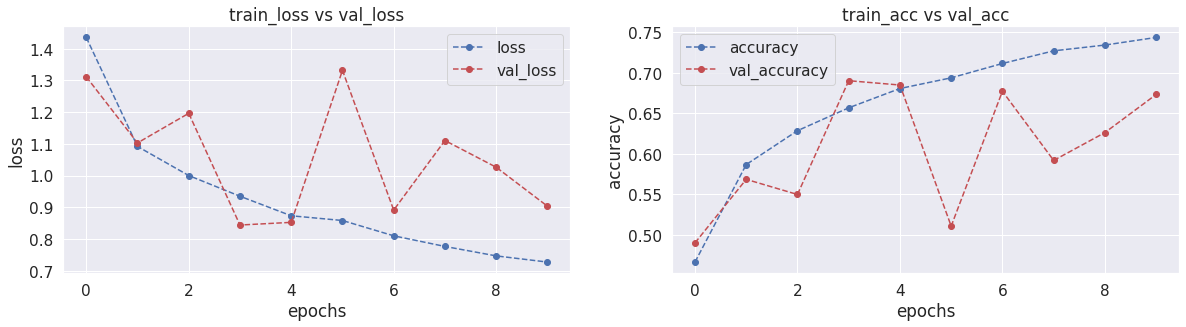

In [26]:
plot_accuracy_loss(history_2)

In [27]:
# The best model weights are loaded into the model
model_2.load_weights(checkpoint_filepath_2)

In [28]:
test_loss_2 = model_2.evaluate(val_ds)

94/94 [==============================] - 3s 31ms/step - loss: 0.8439 - accuracy: 0.6903


## 3. Load data via np.array & augmentation via preprocessing layers

In [29]:
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

In [30]:
def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """
    
    datasets = ['seg_train/seg_train', 'seg_test/seg_test']
    output = []
    train_mode = True
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32') 

        if train_mode:
          images, labels = shuffle(images, labels, random_state=25)
          train_mode = False

        images = images / 255.0  
        
        output.append((images, labels))

    return output

In [31]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading seg_train/seg_train


100%|██████████| 2382/2382 [00:01<00:00, 2035.72it/s]


Loading seg_test/seg_test


100%|██████████| 501/501 [00:00<00:00, 1057.66it/s]


In [32]:
data_augmentation = tf.keras.Sequential([
  RandomFlip("horizontal"),
  RandomRotation(0.2),
  RandomContrast(0.2)
])

### Applied on a model

In [33]:
# Build the model
model_3 = Sequential([
  data_augmentation,                    
  Conv2D(16, 3, padding='same'),
  BatchNormalization(),
  Activation('relu'),
  Dropout(0.1),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  BatchNormalization(),
  Activation('relu'),
  Dropout(0.1),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  BatchNormalization(),
  Activation('relu'),
  Dropout(0.1),
  MaxPool2D(),
  Conv2D(128, 3, padding='same'),
  BatchNormalization(),
  Activation('relu'),
  Dropout(0.1),
  MaxPool2D(),
  Flatten(), # flatten
  Dense(240),
  Activation('relu'),
  Dropout(0.1),
  Dense(120),
  Activation('relu'),
  Dropout(0.1),
  Dense(24),
  Activation('relu'),
  Dropout(0.1),
  Dense(6), # number of neurons same as number of classes
  Activation('softmax')
])

In [34]:
model_3.build(input_shape=(None, 150, 150, 3))
model_3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 150, 150, 16)      448       
                                                                 
 batch_normalization_8 (Batc  (None, 150, 150, 16)     64        
 hNormalization)                                                 
                                                                 
 activation_16 (Activation)  (None, 150, 150, 16)      0         
                                                                 
 dropout_14 (Dropout)        (None, 150, 150, 16)      0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 75, 75, 16)       0         
 2D)                                                  

In [35]:
# Compile the model
model_3.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [36]:
# Fit the model

checkpoint_filepath_3 = '/tmp/checkpoint3'
model_3_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_3,
    save_weights_only=True,
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True)

history_3 = model_3.fit(train_images, train_labels, batch_size=128, epochs=10, callbacks = [model_3_checkpoint_callback], validation_split=0.2)

Epoch 1/10
88/88 [==============================] - ETA: 0s - loss: 1.7410 - accuracy: 0.2725
Epoch 1: val_accuracy improved from -inf to 0.17314, saving model to /tmp/checkpoint3
88/88 [==============================] - 15s 137ms/step - loss: 1.7410 - accuracy: 0.2725 - val_loss: 1.7919 - val_accuracy: 0.1731
Epoch 2/10
88/88 [==============================] - ETA: 0s - loss: 1.5664 - accuracy: 0.3447
Epoch 2: val_accuracy did not improve from 0.17314
88/88 [==============================] - 10s 110ms/step - loss: 1.5664 - accuracy: 0.3447 - val_loss: 1.7942 - val_accuracy: 0.1731
Epoch 3/10
88/88 [==============================] - ETA: 0s - loss: 1.4567 - accuracy: 0.4154
Epoch 3: val_accuracy improved from 0.17314 to 0.18133, saving model to /tmp/checkpoint3
88/88 [==============================] - 10s 111ms/step - loss: 1.4567 - accuracy: 0.4154 - val_loss: 1.9477 - val_accuracy: 0.1813
Epoch 4/10
88/88 [==============================] - ETA: 0s - loss: 1.2147 - accuracy: 0.5253
Ep

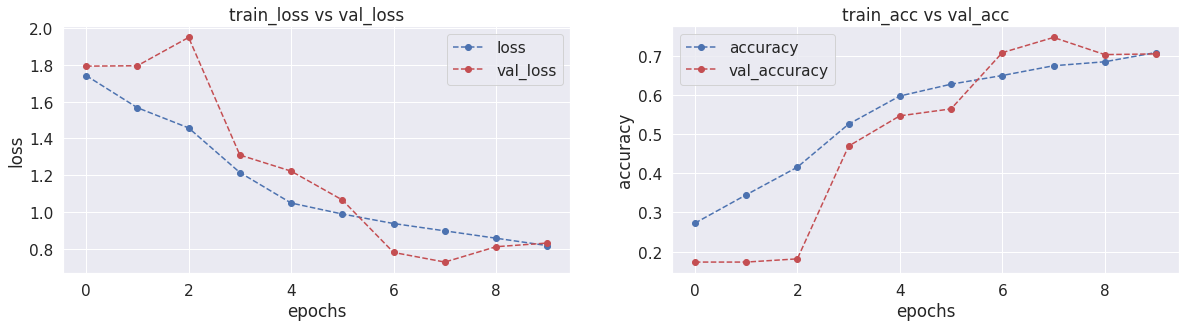

In [37]:
plot_accuracy_loss(history_3)

In [38]:
# The best model weights are loaded into the model
model_3.load_weights(checkpoint_filepath_3)

In [39]:
test_loss_3 = model_3.evaluate(test_images, test_labels)

94/94 [==============================] - 1s 11ms/step - loss: 0.7757 - accuracy: 0.7300
